In [66]:
# Import required libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

### Summary
I used Claude and BeautifulSoup to scrape 216 recent listings from Zillow. I think selected some hyperparameters that gave the highest test score and show the decision tree below.

### Web Scraping (thanks Claude!)

In [67]:
if False:
    import browser_cookie3
    import requests
    import pandas as pd
    import json
    import time
    import random
    from bs4 import BeautifulSoup
    import re
    
    class ZillowScraper:
        def __init__(self):
            # Get Firefox cookies
            self.cookies = browser_cookie3.firefox()
            
            # Setup session with realistic headers
            self.session = requests.Session()
            self.session.headers.update({
                'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:122.0) Gecko/20100101 Firefox/122.0',
                'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
                'Accept-Language': 'en-US,en;q=0.5',
                'Accept-Encoding': 'gzip, deflate, br',
                'DNT': '1',
                'Connection': 'keep-alive',
                'Upgrade-Insecure-Requests': '1',
                'Sec-Fetch-Dest': 'document',
                'Sec-Fetch-Mode': 'navigate',
                'Sec-Fetch-Site': 'none',
                'Sec-Fetch-User': '?1'
            })
    
        def random_sleep(self, min_seconds=2, max_seconds=5):
            time.sleep(random.uniform(min_seconds, max_seconds))
    
        def get_property_data(self, url):
            properties = []
            page = 1
            max_pages = 40  # Limit to 5 pages
            
            try:
                print("\nStarting the scraper...")
                
                while page <= max_pages:
                    print(f"\nScraping page {page}...")
                    
                    if page > 1:
                        if "pagination" in url:
                            current_url = url.replace(
                                "pagination%22%3A%7B%7D",
                                f"pagination%22%3A%7B%22currentPage%22%3A{page}%7D"
                            )
                        else:
                            current_url = url + f"&pagination=%7B%22currentPage%22%3A{page}%7D"
                    else:
                        current_url = url
                    
                    response = self.session.get(current_url)
                    print(f"Status code: {response.status_code}")
                    
                    if response.status_code != 200:
                        print(f"Error accessing page: {response.status_code}")
                        break
                    
                    soup = BeautifulSoup(response.text, 'html.parser')
                    property_cards = soup.find_all('article', class_='property-card')
                    
                    if not property_cards:
                        print("No properties found on this page.")
                        break
                    
                    print(f"Found {len(property_cards)} properties on page {page}")
                    
                    for card in property_cards:
                        try:
                            # Find the property details list
                            details_list = card.find('ul', class_='StyledPropertyCardHomeDetailsList-c11n-8-107-0__sc-1j0som5-0')
                            
                            # Initialize variables
                            beds = baths = sqft = "N/A"
                            
                            # Extract details from list items
                            if details_list:
                                for item in details_list.find_all('li'):
                                    text = item.text.lower()
                                    bold = item.find('b')
                                    if bold:
                                        if 'bds' in text:
                                            beds = bold.text
                                        elif 'ba' in text:
                                            baths = bold.text
                                        elif 'sqft' in text:
                                            sqft = bold.text
                            
                            price_elem = card.find('span', attrs={'data-test': 'property-card-price'})
                            address_elem = card.find('address', attrs={'data-test': 'property-card-addr'})
                            link_elem = card.find('a')
                            
                            property_data = {
                                'price': price_elem.text if price_elem else "N/A",
                                'address': address_elem.text if address_elem else "N/A",
                                'beds': beds,
                                'baths': baths,
                                'sqft': sqft,
                                'link': link_elem['href'] if link_elem else "N/A"
                            }
                            
                            properties.append(property_data)
                            print(f"Scraped: {property_data['address']} - {property_data['sqft']} sqft")
                            
                        except Exception as e:
                            print(f"Error scraping property: {e}")
                            continue
                    
                    page += 1
                    self.random_sleep(2, 4)
                    
            except Exception as e:
                print(f"Error occurred: {e}")
            
            return properties
       
       
    
        def save_to_csv(self, properties, filename='somerville_housing_data.csv'):
            if not properties:
                print("No properties to save!")
                return
                
            df = pd.DataFrame(properties)
            
            # Clean price data
            def clean_price(price):
                if not price or price == "N/A":
                    return 0
                price = price.replace('$', '').replace(',', '')
                if 'K' in price:
                    return float(price.replace('K', '')) * 1000
                elif 'M' in price:
                    return float(price.replace('M', '')) * 1000000
                try:
                    return float(price)
                except ValueError:
                    return 0
            
            # Clean sqft data - handle commas, N/A, --, and lot sizes
            def clean_sqft(sqft):
                if pd.isna(sqft) or sqft in ['N/A', '--']:
                    return 0
                # Extract just the number before 'sqft'
                try:
                    # Remove commas and find the first number
                    sqft_clean = sqft.replace(',', '')
                    number = float(''.join(c for c in sqft_clean.split('sqft')[0] if c.isdigit() or c == '.'))
                    return number
                except (ValueError, IndexError):
                    return 0
                
            df['price'] = df['price'].apply(clean_price)
            df['sqft'] = df['sqft'].apply(clean_sqft)
            
            # Add a lot size column if needed
            def extract_lot_size(sqft):
                if 'lot' in str(sqft).lower():
                    try:
                        sqft_clean = str(sqft).replace(',', '')
                        number = float(''.join(c for c in sqft_clean.split('sqft')[0] if c.isdigit() or c == '.'))
                        return number
                    except (ValueError, IndexError):
                        return 0
                return 0
                
            df['lot_size'] = df['sqft'].apply(extract_lot_size)
            
            df.to_csv(filename, index=False)
            print(f"\nData saved to {filename}")
            print(f"Total properties saved: {len(df)}")
            
            # Print a data summary
            print("\nData Summary:")
            print(f"Average price: ${df['price'].mean():,.2f}")
            print(f"Average sqft: {df['sqft'].mean():,.2f}")
            print(f"Properties with valid sqft: {(df['sqft'] > 0).sum()}")
            print(f"Properties missing sqft: {(df['sqft'] == 0).sum()}")
            print(f"Properties with lot size: {(df['lot_size'] > 0).sum()}")
    
    def main():
        base_url = "https://www.zillow.com/somerville-ma/sold/?searchQueryState=%7B%22pagination%22%3A%7B%7D%2C%22isMapVisible%22%3Atrue%2C%22mapBounds%22%3A%7B%22west%22%3A-71.14134184155273%2C%22east%22%3A-71.06615415844726%2C%22south%22%3A42.360060939680864%2C%22north%22%3A42.43073718476311%7D%2C%22usersSearchTerm%22%3A%22Somerville%20MA%22%2C%22regionSelection%22%3A%5B%7B%22regionId%22%3A54458%2C%22regionType%22%3A6%7D%5D%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22rs%22%3A%7B%22value%22%3Atrue%7D%2C%22fsba%22%3A%7B%22value%22%3Afalse%7D%2C%22fsbo%22%3A%7B%22value%22%3Afalse%7D%2C%22nc%22%3A%7B%22value%22%3Afalse%7D%2C%22cmsn%22%3A%7B%22value%22%3Afalse%7D%2C%22auc%22%3A%7B%22value%22%3Afalse%7D%2C%22fore%22%3A%7B%22value%22%3Afalse%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A14%7D"
        
        scraper = ZillowScraper()
        try:
            properties = scraper.get_property_data(base_url)
            scraper.save_to_csv(properties)
        except KeyboardInterrupt:
            print("\nScript interrupted by user. Saving any data collected...")
            if 'properties' in locals() and properties:
                scraper.save_to_csv(properties)
    
    if __name__ == "__main__":
        main()

### Data Preparation

In [68]:
df = pd.read_csv('../data/somerville_housing_data.csv')
df['beds'] = df['beds'].replace('N/A', 1)
df

,price,address,beds,baths,sqft,link,lot_size
0,1050000.0,"22-22 Lake St #R, Somerville, MA 02143",3,3,1244.0,https://www.zillow.com/homedetails/22-22-Lake-...,0
1,1180000.0,"5 Banks St #2, Somerville, MA 02144",3,2,1795.0,https://www.zillow.com/homedetails/5-Banks-St-...,0
2,1300000.0,"69 Electric Ave, Somerville, MA 02144",5,2,3051.0,https://www.zillow.com/homedetails/69-Electric...,0
3,1270000.0,"41 Oak St #A, Somerville, MA 02143",3,3,1503.0,https://www.zillow.com/homedetails/41-Oak-St-A...,0
4,1050000.0,"71 Bow St #501, Somerville, MA 02143",2,2,1202.0,https://www.zillow.com/homedetails/71-Bow-St-5...,0
...,...,...,...,...,...,...,...
211,1000000.0,"44-46 Sycamore St, Somerville, MA 02143",6,3,2806.0,https://www.zillow.com/homedetails/44-46-Sycam...,0
212,865000.0,"124 Highland Ave #202, Somerville, MA 02143",2,1,905.0,https://www.zillow.com/homedetails/124-Highlan...,0
213,1020000.0,"277 Summer St, Somerville, MA 02144",2,1,1160.0,https://www.zillow.com/homedetails/277-Summer-...,0
214,1020000.0,"751 Somerville Ave #2, Somerville, MA 02143",2,3,1447.0,https://www.zillow.com/homedetails/751-Somervi...,0


In [69]:
# Find columns with dashes
columns_with_dashes = df.columns[df.apply(lambda x: x.astype(str).str.contains('--').any())].tolist()

In [70]:
columns_with_dashes

['beds', 'baths']

In [71]:
print(df[['price', 'beds', 'baths', 'sqft']].dtypes)

price    float64
beds      object
baths     object
sqft     float64
dtype: object


In [72]:
for col in columns_with_dashes:
    df[col] = df[col].replace('--', float('nan'))

In [73]:
df.describe()

,price,sqft,lot_size
count,2.160000e+02,216.000000,216.0
mean,1.082042e+06,1740.777778,0.0
std,4.707534e+05,936.124046,0.0
min,3.330000e+05,0.000000,0.0
25%,7.557500e+05,1068.250000,0.0
50%,1.030000e+06,1530.500000,0.0
75%,1.270000e+06,2191.250000,0.0
max,4.000000e+06,7705.000000,0.0


### Analysis

Best parameters:
Max depth: 4
Min samples leaf: 12
Test R² score: 0.613


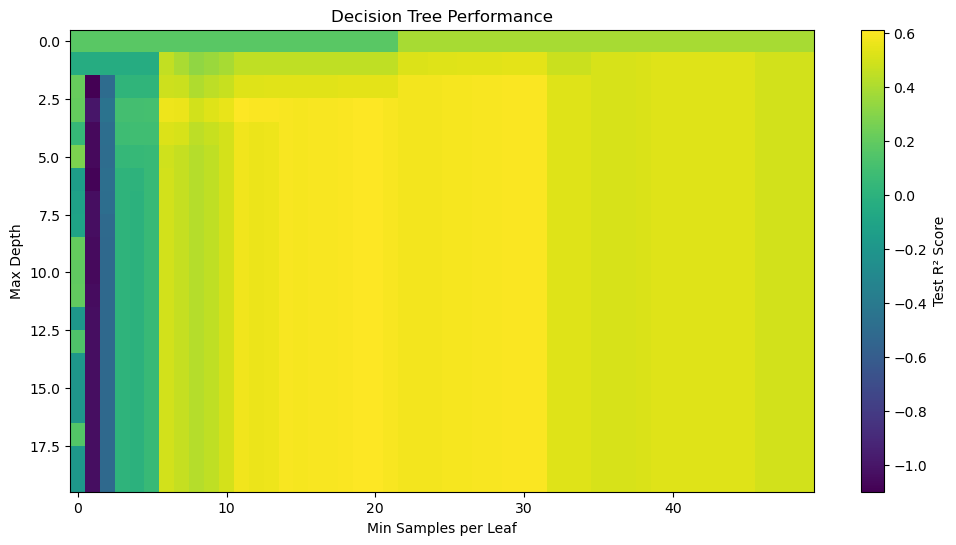

In [74]:
# Target variable
target = 'price'
feature_cols = ['beds', 'baths', 'sqft']

# Create initial feature matrix
X = df[feature_cols].copy()
y = df[target].copy()


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameter grids
max_depths = range(1, 21)
min_samples = range(1, 51)

# Store results
results = []

# Grid search
for depth in max_depths:
    for samples in min_samples:
        dt = DecisionTreeRegressor(max_depth=depth, 
                                 min_samples_leaf=samples, 
                                 random_state=42)
        dt.fit(X_train, y_train)
        test_score = dt.score(X_test, y_test)
        results.append((depth, samples, test_score))

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results, columns=['max_depth', 'min_samples_leaf', 'test_r2'])
best_params = results_df.loc[results_df['test_r2'].idxmax()]

best_max_depth = int(best_params['max_depth'])
best_min_samples = int(best_params['min_samples_leaf'])

print(f"Best parameters:")
print(f"Max depth: {best_max_depth}")
print(f"Min samples leaf: {best_min_samples}")
print(f"Test R² score: {best_params['test_r2']:.3f}")

# Plot results
plt.figure(figsize=(12, 6))
pivot_table = results_df.pivot(index='max_depth', 
                             columns='min_samples_leaf', 
                             values='test_r2')
plt.imshow(pivot_table, aspect='auto')
plt.colorbar(label='Test R² Score')
plt.xlabel('Min Samples per Leaf')
plt.ylabel('Max Depth')
plt.title('Decision Tree Performance')
plt.show()

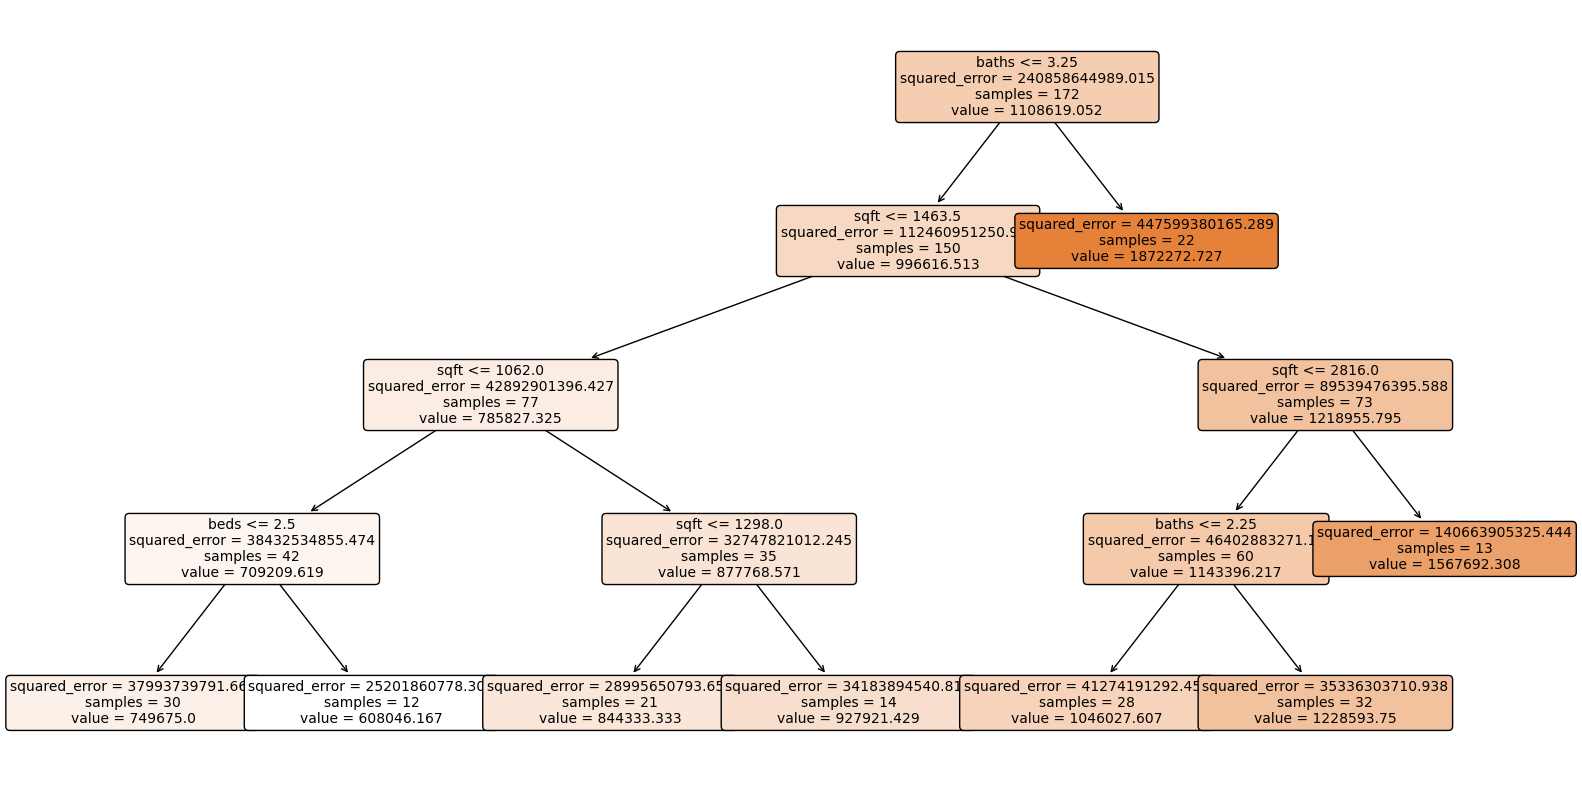

Training R² Score: 0.602
Testing R² Score: 0.613


In [75]:
# Create and train the model
dt = DecisionTreeRegressor(max_depth=best_max_depth, min_samples_leaf=best_min_samples, random_state=42)
dt.fit(X_train, y_train)

# Visualize the tree
plt.figure(figsize=(20,10))
plot_tree(dt, 
          feature_names=list(X_train.columns),
          filled=True, 
          rounded=True,
          fontsize=10)
plt.show()

# Print model performance
train_score = dt.score(X_train, y_train)
test_score = dt.score(X_test, y_test)
print(f"Training R² Score: {train_score:.3f}")
print(f"Testing R² Score: {test_score:.3f}")

Analysis and Reporting:

The R-squared seems reasonable to me, however the depth of the tree is a little concerning given that there aren't many columns.

beds: 0.0069
baths: 0.6099
sqft: 0.3832


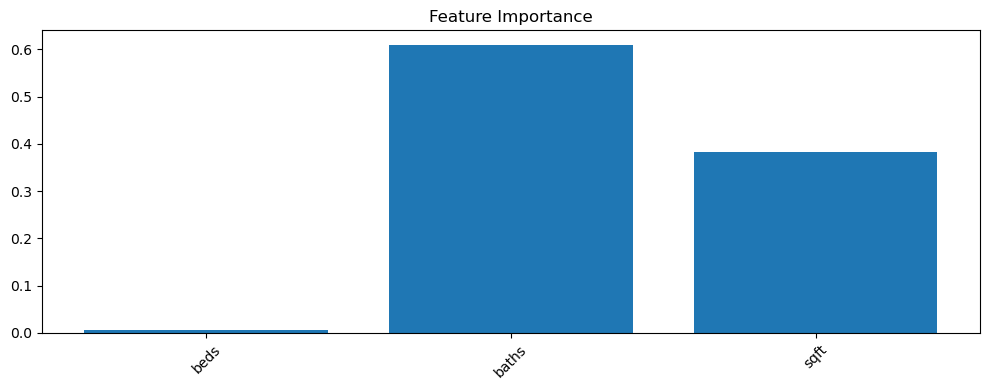

In [80]:
# Get feature importances
importances = dt.feature_importances_
for feature, importance in zip(feature_cols, importances):
   print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(10,4))
plt.bar(feature_cols, importances)
plt.xticks(rotation=45)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

Baths seem to be the most important predictor. I live here and I got a place with 2 bathrooms so maybe that shouldn't surprise me.

### Reflections

The scraping was the hardest part for me. I basically just threw it all at Claude until something stuck. The first 5 or so attempts didn't work with Selenium. Finally, using my actual cookies and lots of random stops seemed to work okay. I'm glad Claude handled the parsing because I've done enough parsing in my life already, although I'm worried that there are some hidden lies in the data. The few examples I checked by hand seemed correct.